# Introduction VisionTransformer

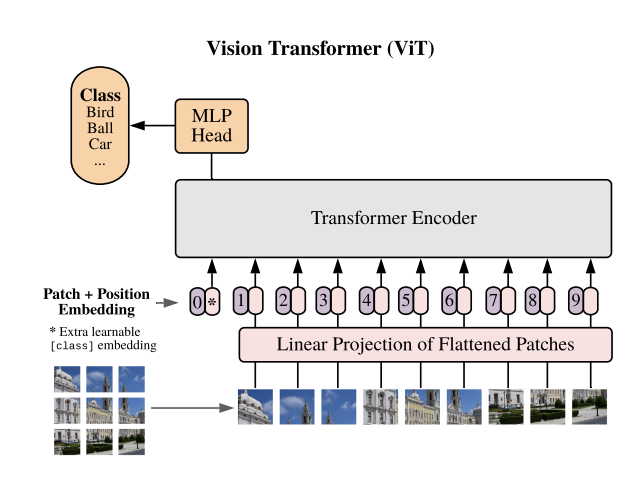 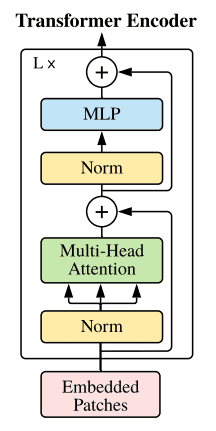

## Import Libraries

In [1]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Load & Preprocessing Dataset
### Cat & Dog Dataset

In [3]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((144,144)),
    torchvision.transforms.ToTensor()
])

In [4]:
train_dataset = torchvision.datasets.ImageFolder("/kaggle/input/cat-and-dog/training_set/training_set", transform=transforms)
test_dataset = torchvision.datasets.ImageFolder("/kaggle/input/cat-and-dog/test_set/test_set", transform=transforms)

In [5]:
train = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)
test = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=32)

In [6]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channel, size, padding, num_of_patches, projection_dim):
        super().__init__()
        self.num_of_patches = num_of_patches + 1
        self.patcher = nn.Conv2d(in_channels=in_channel, out_channels=size*size*3, kernel_size=size, stride=size, padding=padding)
        self.flatten = nn.Flatten(start_dim=2)
        self.projection = nn.Linear(size*size*3, projection_dim)
        self.clsToken = nn.Parameter(torch.rand(1, 1, projection_dim))
        self.positionalEmbedding = nn.Embedding(num_embeddings=self.num_of_patches, embedding_dim=projection_dim)
        
        
    def forward(self, patches):
        #[32, 3, 144, 144]
        patches = self.patcher(patches) #[32, 768, 9, 9]
        patches = self.flatten(patches) #[32, 768, 81]
        patches = patches.permute(0,2,1) #[32, 81, 768]
        patches = self.projection(patches) #[32, 81, 128]
        clsToken = self.clsToken.repeat(patches.shape[0],1,1) #[32, 1, 128]
        patches = torch.cat([clsToken, patches], dim=1) #[32, 82, 128]
        position = torch.arange(0,self.num_of_patches).unsqueeze(0) #[32, 82]
        positionalEmbedding = self.positionalEmbedding(position) #[32, 82, 128]
        patches = patches + positionalEmbedding #[32, 82, 128]
        
        return patches

In [7]:
class TransformerLayer(nn.Module):
    def __init__(self, num_head, embed_dim, dropout_rate = 0.1):
        super().__init__()
        self.layerNorm_1 = nn.LayerNorm(eps=1e-6, normalized_shape=embed_dim)
        self.multi_head_attention = nn.MultiheadAttention(num_heads=num_head, embed_dim=embed_dim, dropout=dropout_rate)
        
        self.layerNorm_2 = nn.LayerNorm(eps=1e-6, normalized_shape=embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Dropout(dropout_rate)
            )
        
    def forward(self, inputs):
        out_1 = self.layerNorm_1(inputs) #[32, 82, 128]
        out_1, _ = self.multi_head_attention(query=out_1, key=out_1, value=out_1) #[32, 82, 128]
        out_1 = inputs + out_1 #[32, 82, 128]
        
        out_2 = self.layerNorm_1(out_1)
        out_2 = self.mlp(out_2) #[32, 82, 128]
        out_2 = out_1 + out_2
        
        return out_2

In [8]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_head, embed_dim, num_layer, dropout_rate=0.1):
        super().__init__()
        self.transformer_layer = [TransformerLayer(num_head=num_head, embed_dim=embed_dim, dropout_rate=dropout_rate) for i in range(num_layer)]
        
    def forward(self, inputs):
        x = inputs
        for layer in self.transformer_layer:
            x = layer(x)
        
        return x

In [9]:
class VIT(nn.Module):
    def __init__(self, in_channel, num_class, size, padding, num_of_patches, projection_dim, num_head, embed_dim, num_layer, dropout_rate=0.1):
        super().__init__()
        self.patchEmbedding = PatchEmbedding(in_channel=in_channel, size=size, padding=padding, num_of_patches=num_of_patches, projection_dim=projection_dim)
        self.transformerEncoder = TransformerEncoder(num_head=num_head, embed_dim=embed_dim, num_layer=num_layer, dropout_rate=dropout_rate)
        self.prediction = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(embed_dim, 256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256,num_class)
        )
        
    def forward(self, x):
        # [32, 3, 144, 144]
        x = self.patchEmbedding(x) #[32, 82, 128]
        x = self.transformerEncoder(x) #[32, 82, 128]
        x = x[:,0,:] #[32, 128]
        x = self.prediction(x) #[32, 2]
        return x

In [10]:
vit_model = VIT(in_channel=3, num_class=2, size=16, padding=0, num_of_patches=81, projection_dim=128, num_head=2, embed_dim=128, num_layer=4).to(device)

In [11]:
optimizer = torch.optim.Adam(vit_model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [12]:
def accuracy(pred, label):
    _,pred_max = torch.max(pred, 1)
    acc = torch.sum(pred_max==label, dtype=torch.float64) / len(pred)
    return acc

In [13]:
for epoch in range(5):
    train_loss = 0.0
    train_acc = 0.0
    test_loss = 0.0
    test_acc = 0.0
    for image, label in tqdm(train):
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        pred = vit_model(image)
        loss = loss_function(pred, label)
        loss.backward()
        optimizer.step()
        
        train_loss += loss
        train_acc += accuracy(pred, label)
    
    for image, label in test:
        image, label = image.to(device), label.to(device)
        pred = vit_model(image)
        loss = loss_function(pred, label)
        
        test_loss += loss
        test_acc += accuracy(pred, label)
        
    total_acc = train_acc / len(train)
    total_val_acc = test_acc / len(test)
    print(f"EPOCHS: {epoch+1}, ACC: {total_acc}, VAL_ACC: {total_val_acc}")

100%|██████████| 251/251 [01:47<00:00,  2.35it/s]


EPOCHS: 1, ACC: 0.49733565737051794, VAL_ACC: 0.5080217633928571


100%|██████████| 251/251 [01:09<00:00,  3.62it/s]


EPOCHS: 2, ACC: 0.4980328685258964, VAL_ACC: 0.5158342633928571


100%|██████████| 251/251 [01:07<00:00,  3.72it/s]


EPOCHS: 3, ACC: 0.5058764940239043, VAL_ACC: 0.5129045758928571


100%|██████████| 251/251 [01:09<00:00,  3.64it/s]


EPOCHS: 4, ACC: 0.49499501992031875, VAL_ACC: 0.50146484375


100%|██████████| 251/251 [01:08<00:00,  3.66it/s]


EPOCHS: 5, ACC: 0.49656374501992034, VAL_ACC: 0.5044642857142857
